# Visualizing metrics of putative IESs in Loxodes magnus MAC vs MIC


Bleties MILRAA used to predict IESs from PacBio HiFi libraries of MIC and MAC, mapped onto the Falcon MAC assembly.

We assume that MAC and MIC purification by FACS is not perfect, but nonetheless still yield statistically significant enrichment of respective target nuclei.

If these are mostly "true" IESs, we expect to see:

 * More IESs should be predicted in MIC library than MAC
 * For overlapping predictions, per-IES retention scores shoud be higher in the MIC library than MAC

We also expect IES lengths to have non-zero modal values, and if similar to Blepharisma possibly also "periodic" length distribution.

However, PacBio HiFi libraries for Loxodes magnus have relatively low coverage (~10-20x), so we may have stretches where coverage is insufficient. Nonetheless we can take advantage of the high read accuracy to call indel presence/absence even when coverage is low.

Show that most of these putative IESs are actually shared in both the MIC and MAC mappings. Those that appear unique are actually due to insufficient coverage.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from scipy import stats
from numpy import log10

In [2]:
plt.rcParams['figure.dpi'] = 72

In [87]:
# Input files
mic_bleties_gff_file = '../bleties/LmagMIC.LmagMAC.milraa_ies_fuzzy.no_overlap_repeats.gff3'
mac_bleties_gff_file = '../bleties/LmagMAC.LmagMAC.milraa_ies_fuzzy.no_overlap_repeats.gff3'

## Import data

In [3]:
def gff2df(gff_list, attr_to_extract):
    """Convert GFF records (list of lists) to pandas data frame
    
    Also extract specified attributes as additional columns.
    
    Parameters
    ----------
    gff_list : list
        GFF records as list of lists
    attr_to_extract : list
        List of attributes to extract from 'attributes' field of GFF
    """
    GFF_COLUMNS = ['seqid','source','type','start','end','score','strand','phase','attributes']
    df = pd.DataFrame(gff_list, columns=GFF_COLUMNS)
    df['start'] = pd.to_numeric(df['start'])
    df['end'] = pd.to_numeric(df['end'])
    df['score'] = pd.to_numeric(df['score'])
    for attr in attr_to_extract:
        df[attr] = df['attributes'].str.extract(rf"{attr}=([^;]+)")
    return(df)

In [5]:
# "IES" indels detected by MILRAA from MIC library mapped onto MAC assembly
mic_recs = []
with open(mic_bleties_gff_file, "r") as fh:
    for line in fh:
        mic_recs.append(line.rstrip().split("\t"))

In [6]:
# "IES" indels detected by MILRAA from MAC library mapped onto MAC assembly
mac_recs = []
with open(mac_bleties_gff_file, "r") as fh:
    for line in fh:
        mac_recs.append(line.rstrip().split("\t"))

In [7]:
mic_df = gff2df(mic_recs, ['ID','IES_length', 'average_coverage', 'cigar'])
#mic_df['average_coverage'] = pd.to_numeric(mic_df['average_coverage'])
mic_df['lib'] = 'mic'

In [8]:
mac_df = gff2df(mac_recs, ['ID','IES_length', 'average_coverage', 'cigar'])
#mac_df['average_coverage'] = pd.to_numeric(mac_df['average_coverage'])
mac_df['lib'] = 'mac'

In [11]:
# Combine MIC and MAC tables
ies_df = pd.concat([mic_df, mac_df])

In [12]:
ies_df['average_coverage'] = pd.to_numeric(ies_df['average_coverage'])

In [13]:
ies_df.head()['attributes'][2]

'ID=BREAK_POINTS_FUZZY_000000F_194134_194134_861;IES_length=861_859;cigar=861I*2 860I*1 862I*1 863I*1 859I*2;average_coverage=19;pointer_seq=ACAGTTATAAGAAATA;ta_pointer_seq=TATAAGAAATA;ta_pointer_start=194139;ta_pointer_end=194139;'

In [14]:
# Check if TA-bound and/or pointer sequence and length
ies_df['ta_bound'] = ies_df['attributes'].str.contains('ta_pointer')
ies_df['pointer_seq'] = ies_df['attributes'].str.extract(r';pointer_seq\=([ATCG]+);').fillna('')
ies_df['pointer_len'] = ies_df['pointer_seq'].str.len()

In [15]:
ies_df.head()

,seqid,source,type,start,end,score,strand,phase,attributes,ID,IES_length,average_coverage,cigar,lib,ta_bound,pointer_seq,pointer_len
0,000000F,MILRAA,internal_eliminated_sequence_junction,176,176,0.7222,.,.,ID=BREAK_POINTS_000000F_176_176_30;IES_length=...,BREAK_POINTS_000000F_176_176_30,30,18,30I*13,mic,False,,0
1,000000F,MILRAA,internal_eliminated_sequence_junction,52627,52627,0.4828,.,.,ID=BREAK_POINTS_000000F_52627_52627_36;IES_len...,BREAK_POINTS_000000F_52627_52627_36,36,29,36I*14,mic,False,AGGTT,5
2,000000F,MILRAA,internal_eliminated_sequence_junction,194134,194134,0.3684,.,.,ID=BREAK_POINTS_FUZZY_000000F_194134_194134_86...,BREAK_POINTS_FUZZY_000000F_194134_194134_861,861_859,19,861I*2 860I*1 862I*1 863I*1 859I*2,mic,True,ACAGTTATAAGAAATA,16
3,000000F,MILRAA,internal_eliminated_sequence_junction,194748,194748,0.4815,.,.,ID=BREAK_POINTS_FUZZY_000000F_194748_194748_14...,BREAK_POINTS_FUZZY_000000F_194748_194748_146,146,27,145I*1 146I*11 147I*1,mic,False,CAAA,4
4,000000F,MILRAA,internal_eliminated_sequence_junction,195279,195279,0.3636,.,.,ID=BREAK_POINTS_000000F_195279_195279_15;IES_l...,BREAK_POINTS_000000F_195279_195279_15,15,33,15I*12,mic,True,TA,2


## Length distribution

In [16]:
# Reformat IES lengths which were encoded as underscore-delimited lists 
# of lengths because there was more than one insert size
conv = []
for i in ies_df['IES_length']:
    i = [int(j) for j in i.split("_")]
    if len(i) > 1:
        i = float(sum(i) / len(i))
    else:
        i = i[0]
    conv.append(i)
ies_df['IES_length'] = conv

In [17]:
ies_df['IES_length_log10'] = log10(ies_df['IES_length'])

In [18]:
# Number of IES predictions per library
ies_df.groupby('lib').size()

lib
mac    12897
mic    13734
dtype: int64

Combine into single plot

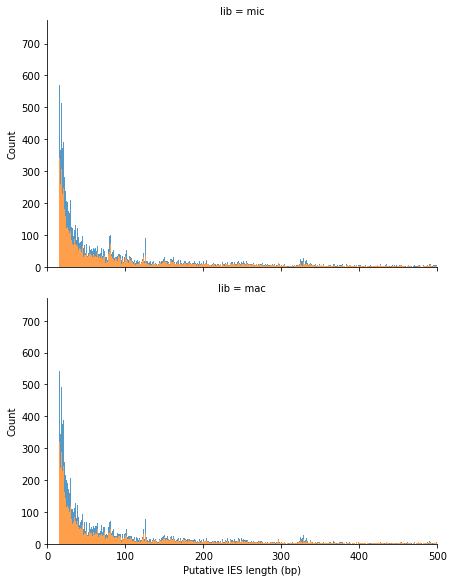

In [19]:
# Combine into plot
g = sns.FacetGrid(
    data=ies_df.query('IES_length<=500'), 
    row='lib', xlim=(0,500), height=4, aspect=1.5)
g.map_dataframe(
    sns.histplot,
    x='IES_length',
    hue='ta_bound', hue_order=[True,False], multiple='stack',
    discrete=True, linewidth=0)
g.add_legend()
g.set_xlabels("Putative IES length (bp)")
g.set_ylabels("Count")
plt.savefig("plots/putative_ies_length_distribution.png")
plt.savefig("plots/putative_ies_length_distribution.pdf")

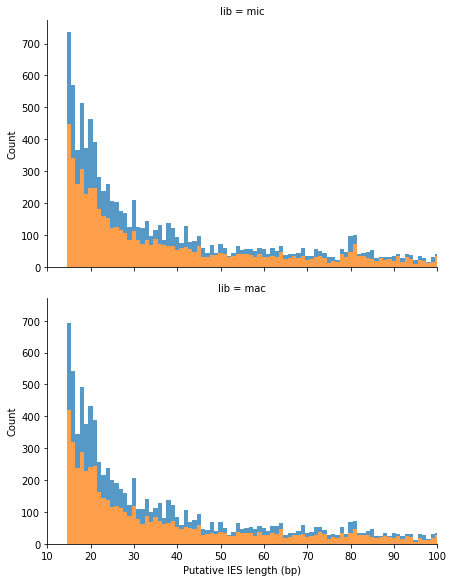

In [20]:
g = sns.FacetGrid(
    data=ies_df.query('IES_length<=100'), 
    row='lib', 
    xlim=(10,100), height=4, aspect=1.5)
g.map_dataframe(
    sns.histplot, 
    x='IES_length', 
    hue='ta_bound', hue_order=[True,False], multiple='stack',
    discrete=True, linewidth=0)
g.add_legend()
g.set_xlabels("Putative IES length (bp)")
g.set_ylabels("Count")
plt.savefig("plots/putative_ies_length_distribution_detail.png")
plt.savefig("plots/putative_ies_length_distribution_detail.pdf")

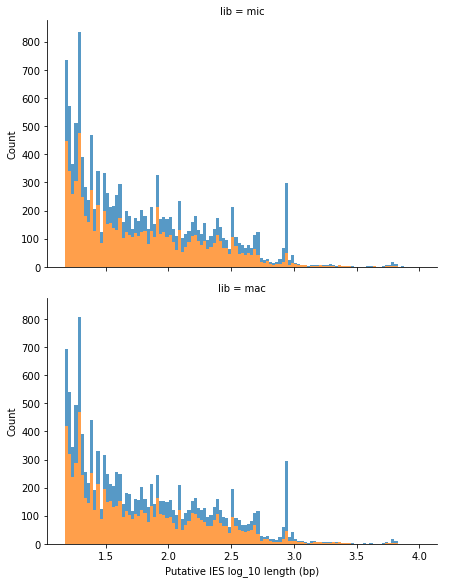

In [21]:
# As log scale
g = sns.FacetGrid(
    data=ies_df, 
    row='lib', 
    height=4, aspect=1.5)
g.map_dataframe(
    sns.histplot, 
    x='IES_length_log10', 
    binwidth=0.025,
    hue='ta_bound', hue_order=[True,False], multiple='stack',
    linewidth=0)
g.add_legend()
g.set_xlabels("Putative IES log_10 length (bp)")
g.set_ylabels("Count")
#plt.savefig("plots/putative_ies_length_distribution_detail.png")
#plt.savefig("plots/putative_ies_length_distribution_detail.pdf")

In [22]:
ies_df.query('IES_length_log10 <=3.0 and IES_length_log10 >2.8').shape

(1008, 18)

In [23]:
ies_df.query('IES_length_log10 <=3.0 and IES_length_log10 >2.8').head()

,seqid,source,type,start,end,score,strand,phase,attributes,ID,IES_length,average_coverage,cigar,lib,ta_bound,pointer_seq,pointer_len,IES_length_log10
2,000000F,MILRAA,internal_eliminated_sequence_junction,194134,194134,0.3684,.,.,ID=BREAK_POINTS_FUZZY_000000F_194134_194134_86...,BREAK_POINTS_FUZZY_000000F_194134_194134_861,860.0,19,861I*2 860I*1 862I*1 863I*1 859I*2,mic,True,ACAGTTATAAGAAATA,16,2.934498
9,000000F,MILRAA,internal_eliminated_sequence,637865,638718,0.5238,.,.,ID=BREAK_POINTS_000000F_637865_638718_854;IES_...,BREAK_POINTS_000000F_637865_638718_854,854.0,21,854D*10,mic,True,TATTACT,7,2.931458
22,000000F,MILRAA,internal_eliminated_sequence,2772231,2773076,0.5862,.,.,ID=BREAK_POINTS_000000F_2772231_2773076_846;IE...,BREAK_POINTS_000000F_2772231_2773076_846,846.0,29,846D*12,mic,True,AAAATTTAAAATCCT,15,2.927370
33,000001F,MILRAA,internal_eliminated_sequence,441488,442329,0.5000,.,.,ID=BREAK_POINTS_000001F_441488_442329_842;IES_...,BREAK_POINTS_000001F_441488_442329_842,842.0,24,842D*12,mic,True,TTATTATTATAGATAT,16,2.925312
52,000001F,MILRAA,internal_eliminated_sequence,2341818,2342670,0.4516,.,.,ID=BREAK_POINTS_000001F_2341818_2342670_853;IE...,BREAK_POINTS_000001F_2341818_2342670_853,853.0,31,853D*17,mic,True,TTAAGATTATAAATA,15,2.930949


## Average coverage: "IESs" that are at coverage anomalies

Are "IESs" more likely to be predicted at coverage anomalies? 

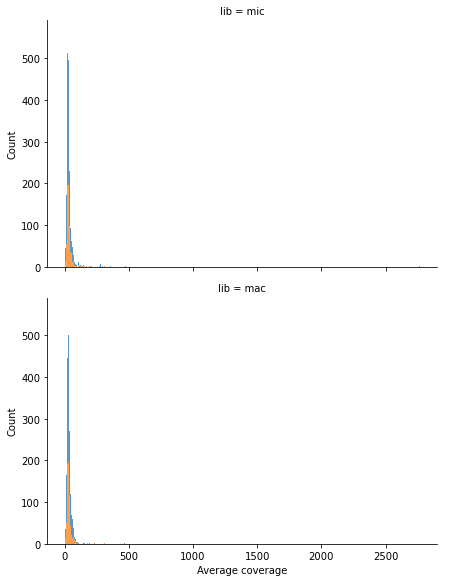

In [24]:
g = sns.FacetGrid(
    data=ies_df, row='lib', height=4, aspect=1.5)
g.map_dataframe(
    sns.histplot, 
    x='average_coverage', 
    hue='ta_bound', multiple='stack',
    discrete=True, linewidth=0)
g.add_legend()
g.set_xlabels("Average coverage")
g.set_ylabels("Count")
plt.savefig("plots/putative_ies_average_coverage.png")
plt.savefig("plots/putative_ies_average_coverage.pdf")

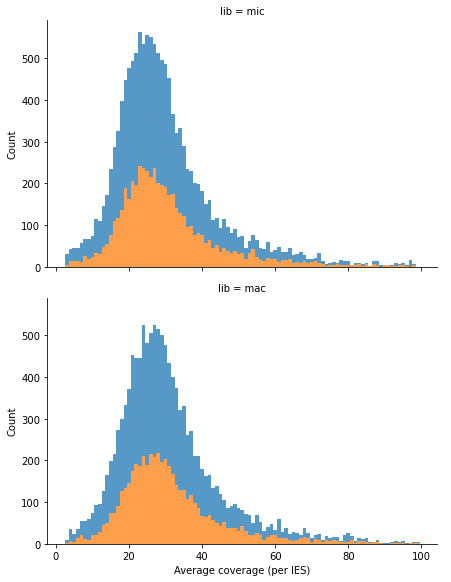

In [25]:
g = sns.FacetGrid(
    data=ies_df.query('average_coverage < 100'), row='lib', height=4, aspect=1.5)
g.map_dataframe(
    sns.histplot, 
    x='average_coverage', 
    hue='ta_bound', multiple='stack',
    discrete=True, linewidth=0)
g.add_legend()
g.set_xlabels("Average coverage (per IES)")
g.set_ylabels("Count")
plt.savefig("plots/putative_ies_average_coverage_detail.png")
plt.savefig("plots/putative_ies_average_coverage_detail.pdf")

## Retention scores

In [26]:
# convert 'type' field to simpler 'indel' column
type2indel = {'internal_eliminated_sequence' : 'del', 'internal_eliminated_sequence_junction' : 'ins'}
ies_df['indel'] = ies_df['type'].apply(lambda x: type2indel[x])

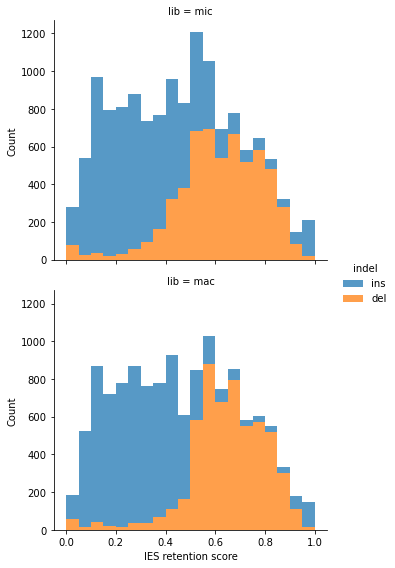

In [27]:
g = sns.displot(
    data=ies_df, x='score', hue='indel', row='lib', 
    kind='hist', binwidth=0.05, multiple='stack', linewidth=0,
    height=4, aspect=1.2)
g.set_xlabels("IES retention score")
plt.savefig("plots/putative_ies.mic_v_mac_ies_retention_scores.png")
plt.savefig("plots/putative_ies.mic_v_mac_ies_retention_scores.pdf")

NB: sns.FacetGrid does not work well with stacked histogram plots. If the `hue` parameter is specified at `sns.FacetGrid`, then the `multiple='stack'` parameter does not work when passed to histplot. If the `hue` parameter is specified at `map_dataframe`, then the hues may differ between panels, and the `add_legend` function does not work. Suggested solution from seaborn developer is to use `displot()` instead of `FacetGrid` for facetting distribution-type plots.

## Unique vs shared IESs

If IESs were real, we expect them to have higher retention score in the MIC mapping than the MAC.

For putative IESs predicted in both libraries (same coordinates), we compare the retention scores in MIC vs. MAC and test whether the former is higher than the latter.

For those that are predicted in only one library, we reason that they are likely to be the result of low coverage. So we dig into the appropriate mapping and search for them there, too.

In [43]:
# pull list of start/end coordinates
mic_recs_list = {(i[1],i[2],i[3]) : i[4] for i in list(mic_df[['seqid','start','end','ID']].to_records())}
mac_recs_list = {(i[1],i[2],i[3]) : i[4] for i in list(mac_df[['seqid','start','end','ID']].to_records())}
# get lists of putative iESs shared and unique in either set
mic_shared_recs_list = [mic_recs_list[i] for i in mic_recs_list if i in mac_recs_list]
mac_shared_recs_list = [mac_recs_list[i] for i in mac_recs_list if i in mic_recs_list]

In [44]:
def flag_unique(x):
    if x['lib']  == 'mic' and x['ID'] in mic_shared_recs_list:
        return(False)
    elif x['lib'] == 'mac' and x['ID'] in mac_shared_recs_list:
        return(False)
    else:
        return(True)

In [47]:
# Label IESs as unique or shared
ies_df['uniq'] = ies_df.apply(lambda x: flag_unique(x), axis=1)

### Compare retention scores of shared predicted IESs

In [31]:
# Get IESs with same coordinates predicted in MIC vs MAC libraries (with dataframe operations)
mic_df_shared = ies_df[ies_df['ID'].isin(mic_shared_recs_list)].query('lib == "mic"')[['seqid','start','end','score']]
mac_df_shared = ies_df[ies_df['ID'].isin(mac_shared_recs_list)].query('lib == "mac"')[['seqid','start','end','score']]
# rename score column as 'mic_score' and 'mac_score'
mic_df_shared.rename(columns={'score':'mic_score'}, inplace=True)
mac_df_shared.rename(columns={'score':'mac_score'}, inplace=True)


In [56]:
# Extract MIC and MAC retention scores for shared IESs. 
# Note that IDs may not be the same between the two libraries because predicted lengths can differ
ies_df_shared = ies_df.query('not uniq'
    )[['seqid','start','end','lib','score']].pivot(
        index=['seqid','start','end'], 
        columns='lib',
        values='score'
    ).reset_index()

Text(0, 0.5, 'Retention score in MIC')

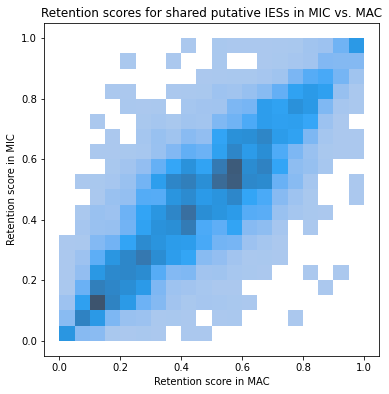

In [57]:
# scatterplot retention scores in MIC vs MAC libraries for putative IESs found in both
plt.figure(figsize=(6,6))
sns.histplot(data=ies_df_shared,x='mac',y='mic', binwidth=0.05)
plt.title("Retention scores for shared putative IESs in MIC vs. MAC")
plt.xlabel("Retention score in MAC")
plt.ylabel("Retention score in MIC")
#plt.savefig("plots/putative_ies.mic_v_mac_ies_retention_scores_heatmap.png")
#plt.savefig("plots/putative_ies.mic_v_mac_ies_retention_scores_heatmap.pdf")

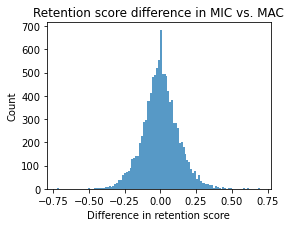

In [59]:
# histogram of retention score differences in MIC vs MAC libraries
# if no difference, should cluster around zero
plt.figure(figsize=(4,3))
sns.histplot(
    data=ies_df_shared['mic']-ies_df_shared['mac'],
    linewidth=0)
plt.title("Retention score difference in MIC vs. MAC")
plt.xlabel("Difference in retention score")
plt.savefig("plots/putative_ies.mic_v_mac_ies_retention_scores_difference.png")
plt.savefig("plots/putative_ies.mic_v_mac_ies_retention_scores_difference.pdf")

In [60]:
print("Statistical tests for retention score differences:")
print("paired t-test (scipy >=1.6 is needed for `alternative` parameter")
print(stats.ttest_rel(ies_df_shared['mic'], ies_df_shared['mac']))

Statistical tests for retention score differences:
paired t-test (scipy >=1.6 is needed for `alternative` parameter
Ttest_relResult(statistic=1.235269272119551, pvalue=0.21675670947295975)


In [61]:
print("Nonparametric tests, because cannot assume that data are normally distributed")
print("One-sided, MIC greater:")
print(stats.wilcoxon(ies_df_shared['mic'], ies_df_shared['mac'], alternative='greater'))
print("Two-sided")
print(stats.wilcoxon(ies_df_shared['mic']-ies_df_shared['mac'], alternative='two-sided'))

Nonparametric tests, because cannot assume that data are normally distributed
One-sided, MIC greater:
WilcoxonResult(statistic=29094687.0, pvalue=0.2939432192775272)
Two-sided
WilcoxonResult(statistic=28745703.0, pvalue=0.5878864385550544)


In [62]:
stats.describe(ies_df_shared['mic']-ies_df_shared['mac'])

DescribeResult(nobs=10992, minmax=(-0.7192999999999999, 0.7), mean=0.0014734807132459977, variance=0.015640201876046575, skewness=0.08845573783506545, kurtosis=1.328897340313823)

Difference between retention scores in IESs from MIC vs. MAC libraries is not statistically significant (one sided test for MIC score greater than MAC score).

This is consistent with our hypothesis that the "IESs" are in fact indel polymorphisms. Retention scores ~0.5 is consistent with 1:1 ratio of alleles in a diploid organism.

### Examine MIC-unique IESs

Even if the majority of "IESs" are indel polymorphisms, it remains possible that there are true IESs hidden among them. We would expect to see these in the IESs predicted only from the MIC library, and they should have retention scores > 0.5.

In [71]:
# Overall mean retention score - close to 0.5
ies_df['score'].mean()

0.45607116142841053

In [73]:
# Summary of retention scores by library
ies_df.groupby(['lib'])['score'].describe()

,count,mean,std,min,25%,50%,75%,max
lib,,,,,,,,
mac,12897.0,0.459323,0.241191,0.0,0.25,0.4510,0.6500,1.0
mic,13734.0,0.453017,0.240889,0.0,0.25,0.4545,0.6327,1.0


In [70]:
# Summary of retention scores grouped by whether "IES" is shared or unique
ies_df.groupby('uniq')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
uniq,,,,,,,,
False,21984.0,0.465644,0.225895,0.0,0.2857,0.4643,0.6316,1.0
True,4647.0,0.410783,0.298532,0.0,0.1429,0.2917,0.7222,1.0


In [74]:
# Summary of retention scores grouped by library and whether insert or deletion
ies_df.groupby(['lib','indel'])['score'].describe()

count      mean       std     min       25%     50%     75%  \
lib indel                                                                 
mac del    5562.0  0.645992  0.159307  0.0000  0.565200  0.6538  0.7568   
    ins    7335.0  0.317776  0.191266  0.0033  0.176500  0.2941  0.4167   
mic del    5750.0  0.616218  0.175314  0.0000  0.514300  0.6286  0.7500   
    ins    7984.0  0.335482  0.211399  0.0014  0.168425  0.3000  0.4545   

              max  
lib indel          
mac del    0.9876  
    ins    1.0000  
mic del    0.9815  
    ins    1.0000

In [67]:
# Summary of retention scores grouped by library, indel and shared/unique
ies_df.groupby(['lib','uniq','indel'])['score'].describe()

count      mean       std     min      25%     50%  \
lib uniq  indel                                                        
mac False del    4779.0  0.630435  0.155373  0.0000  0.55560  0.6364   
          ins    6213.0  0.337584  0.190206  0.0033  0.20000  0.3243   
    True  del     783.0  0.740945  0.149899  0.0000  0.67655  0.7727   
          ins    1122.0  0.208086  0.156964  0.0063  0.10000  0.1724   
mic False del    4779.0  0.598642  0.169198  0.0000  0.50000  0.6061   
          ins    6213.0  0.364647  0.206663  0.0014  0.20690  0.3448   
    True  del     971.0  0.702721  0.179259  0.0000  0.63640  0.7391   
          ins    1771.0  0.233165  0.195454  0.0053  0.11480  0.1765   

                      75%     max  
lib uniq  indel                    
mac False del    0.729700  0.9876  
          ins    0.428600  1.0000  
    True  del    0.837800  0.9742  
          ins    0.253675  1.0000  
mic False del    0.721200  0.9815  
          ins    0.480000  1.0000  
    True  del    0.821800  0.9762  
          ins    0.276850  1.0000

If predicted IESs unique to the MIC are true IESs, then we expect them to be predominantly inserts relative to the MAC reference genome, and to have retention score higher than 50% because the MICs were physically enriched.

However, MIC-unique "IESs" comprised both insertions and deletions; the retention scores were lower than average for the former, and higher than average for the latter. The same pattern was observed for MAC-unique "IESs". This suggests that these indels are not truly unique to MIC or MAC libraries but simply not detected in one or the other library because of sampling effects, and "unique" IESs are simply statistical outliers.

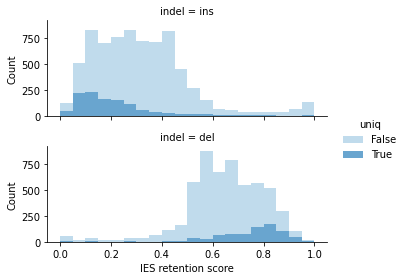

In [75]:
g = sns.displot(
    data=ies_df.query('lib=="mac"'), x='score', 
    hue='uniq', palette='Blues',
    row='indel', 
    #row='lib',
    kind='hist', binwidth=0.05, multiple='stack', 
    linewidth=0,
    height=2, aspect=2.4)
g.set_xlabels("IES retention score")

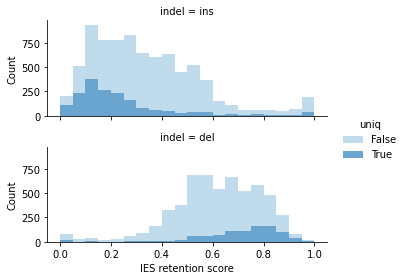

In [76]:
g = sns.displot(
    data=ies_df.query('lib=="mic"'), x='score', 
    hue='uniq', palette='Blues',
    row='indel', 
    #row='lib',
    kind='hist', binwidth=0.05, multiple='stack', 
    linewidth=0,
    height=2, aspect=2.4)
g.set_xlabels("IES retention score")

This is confirmed if we plot distribution of retention scores vs. average coverage of flanking regions. 

The genome-wide average coverage is around 20-30x. Shared indels mostly have coverage in that range and retention scores around 50%.

However unique IESs with very high or very low retention scores are associated with low coverage regions, i.e. they are likely due to sampling artiacts.

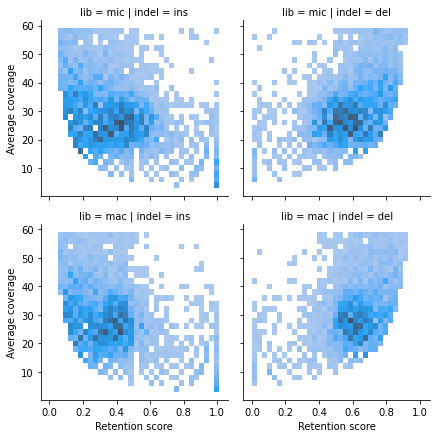

In [106]:
# Plot average coverage vs. retention score.
# Observe that "IESs" with high retention score tend to be in low coverage regions
# i.e. are likely sampling artifacts
# Average coverage 20-30 for most regions
g = sns.FacetGrid(
    data=ies_df.query('average_coverage<60 and not uniq'),
    row='lib', col='indel', col_order=['ins','del']
    )
g.map_dataframe(
    sns.histplot,
    x='score', y='average_coverage', hue='indel', binwidth=(0.03, 2)
)
g.set_xlabels('Retention score')
g.set_ylabels('Average coverage')
g.savefig('plots/putative_IES.retention_score_vs_avg_coverage.png')
g.savefig('plots/putative_IES.retention_score_vs_avg_coverage.pdf')

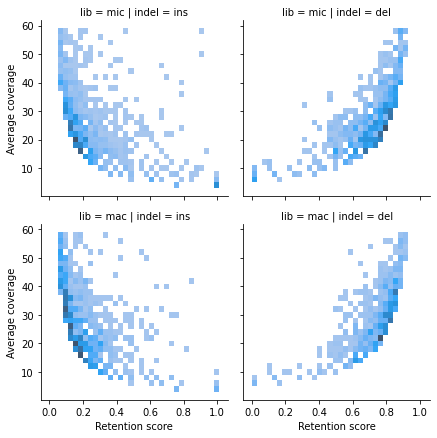

In [107]:
# Plot coverage vs. retention score for "IESs" that are only predicted in MIC 
# or only predicted in MAC library ("unique")
g = sns.FacetGrid(
    data=ies_df.query('uniq and average_coverage<60'),
    row='lib', col='indel', col_order=['ins','del']
    )
g.map_dataframe(
    sns.histplot,
    x='score', y='average_coverage', binwidth=(0.03, 2)
)
g.set_xlabels('Retention score')
g.set_ylabels('Average coverage')
g.savefig('plots/putative_IES.retention_score_vs_avg_coverage.only_unique.png')
g.savefig('plots/putative_IES.retention_score_vs_avg_coverage.only_unique.pdf')

In [102]:
# "IES" insertions unique to the MIC and with high retention score are few in number and have low flanking coverage
ies_df.query('score > 0.9').groupby(['lib','uniq','indel'])['average_coverage'].describe()

count        mean        std   min    25%   50%     75%  \
lib uniq  indel                                                            
mac False del     63.0   98.698413  68.500444  51.0  62.50  77.0   98.50   
          ins    181.0   15.348066  10.724601   3.0   7.00  14.0   20.00   
    True  del     49.0   84.653061  38.847754  51.0  65.00  72.0   83.00   
          ins      9.0    4.444444   2.127858   3.0   3.00   3.0    6.00   
mic False del     56.0  118.089286  80.267117  53.0  62.75  81.5  154.25   
          ins    205.0   15.248780  10.810378   3.0   8.00  13.0   20.00   
    True  del     46.0   98.630435  62.551795  51.0  60.50  78.0  100.25   
          ins     40.0    4.200000   1.989717   3.0   3.00   4.0    4.25   

                   max  
lib uniq  indel         
mac False del    485.0  
          ins     74.0  
    True  del    233.0  
          ins      9.0  
mic False del    377.0  
          ins     66.0  
    True  del    311.0  
          ins     15.0

# TDR length distribution

Length distribution of TDRs bounding the "IES" indels, comparing observed to expected numbers of IESs with TDRs of given lengths. Also show the prevalence of TDRs containing the submotif "TA"

In [82]:
(100-26)/2

37.0

Calculation of expected number of TIRs

GC% = 26%, so the individual base composition: p_G = 0.13, p_C = 0.13, p_A = 0.37, p_T = 0.37

In [83]:
pr_sum = sum([0.13**2, 0.13**2, 0.37**2, 0.37**2])

In [84]:
ies_df.shape[0] # Total number of IESs

26631

In [85]:
expected_tirs = pd.DataFrame(
    [(i, ies_df.shape[0] * pr_sum**i * (1-pr_sum)) for i in range(50)],
    columns=['pointer_len', 'Count'])

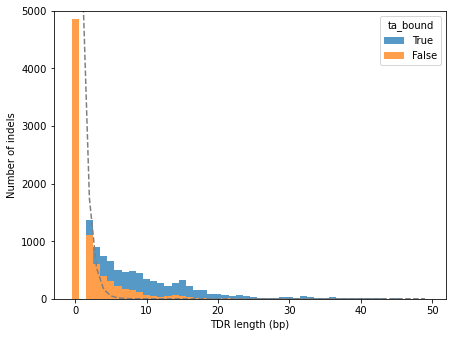

In [86]:
fig, axs = plt.subplots()
sns.histplot(
    data=ies_df.query('pointer_len < 50').query('lib=="mic"'),
    x='pointer_len',
    hue='ta_bound', hue_order=[True,False],
    discrete=True,
    multiple='stack',
    linewidth=0, ax=axs)
sns.lineplot(
    data=expected_tirs,
    x='pointer_len',y='Count',
    color='grey',
    ax=axs)
axs.set_ylim(0,5000)
axs.lines[0].set_linestyle("--")
fig.tight_layout()
axs.set_xlabel("TDR length (bp)")
axs.set_ylabel("Number of indels")
#axs.set_yscale('symlog')
fig.savefig('plots/putative_ies.observed_expected_TDR_length.pdf')
fig.savefig('plots/putative_ies.observed_expected_TDR_length.png')